# Model : One Neuron Network

### Features: Embeddings + exam stage + picture (boolean)
### Model: Simple Neural Network

In [57]:
# Import libraries/frameworks
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
tf.random.set_seed(1)

df = pd.read_excel( 'train_final.xlsx' )
test_data = pd.read_excel( 'test_final.xlsx' )
test_target = pd.read_excel( 'gold_final.xlsx' )
df.fillna(0, inplace=True)
df.head(2)

,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,Answer__I,Answer__J,Answer_Key,Answer_Text,ItemType,EXAM,Difficulty,Response_Time
0,91,"Over 1 year, a study is conducted to assess th...",Case-control study,Crossover study,Open-labeled clinical trial,Randomized clinical trial,"Single-blind, randomized, controlled trial",0,0,0,0,0,C,Open-labeled clinical trial,Text,STEP 1,0.86,111.21
1,288,A previously healthy 52-year-old woman comes t...,Calcitriol production by activated macrophages,Local resorption of bone by metastases,Parathyroid hormone-related peptide secretion,Secretion of parathyroid hormone,Secretion of thyroid-stimulating hormone,0,0,0,0,0,A,Calcitriol production by activated macrophages,Text,STEP 1,0.44,83.94


In [58]:
test_data[test_data['Answer_Text'].isna()] #.isna().sum()

,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,Answer__I,Answer__J,Answer_Key,Answer_Text,ItemType,EXAM
187,167,A 25-year-old man volunteers to participate in...,NO BASE XML,NO BASE XML,NO BASE XML,NO BASE XML,NO BASE XML,NO BASE XML,NO BASE XML,NO BASE XML,NaN,NaN,H,NaN,PIX,STEP 1


In [59]:
test_data = pd.merge( test_data, test_target, on = 'ItemNum' ) 

In [60]:
test_data.head(2)

,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,Answer__I,Answer__J,Answer_Key,Answer_Text,ItemType,EXAM,Difficulty,Response_Time
0,552,A 78-year-old woman undergoes an outpatient la...,Gastroduodenal,Left gastric,Left hepatic,Right gastric,Right hepatic,NaN,NaN,NaN,NaN,NaN,E,Right hepatic,Text,STEP 1,0.52,75.21
1,16,A 48-year-old man dies suddenly of a cardiac a...,Acute inflammation,Fibrinous exudate,Fibrous scar,Granulation tissue,Normal kidney,NaN,NaN,NaN,NaN,NaN,E,Normal kidney,Text,STEP 1,0.70,80.88


In [61]:
test_data.fillna( 0, inplace=True) 

df['ItemType_num'] = df.ItemType.apply(lambda x: 0 if x == 'PIX' else 1 ) 
test_data['ItemType_num'] = test_data.ItemType.apply(lambda x: 0 if x == 'PIX' else 1 ) 

def vectorizeEXAM(x):
    if x == 'STEP 1' : 
        return .33
    elif x == 'STEP 2' : 
        return .66
    else: 
        return 1.0
df['EXAM_num'] = df.EXAM.apply( vectorizeEXAM )
test_data['EXAM_num'] = test_data.EXAM.apply( vectorizeEXAM )

print(df['EXAM_num'].value_counts())

X_cols = ['ItemStem_Text', 'Answer__A', 'Answer__B', 'Answer__C', 'Answer__D', 'Answer__E', 'Answer__F', 'Answer__G', 'Answer__H', \
           'Answer__I', 'Answer__J', 'Answer_Text'] 
X_num = [ 'ItemType_num', 'EXAM_num' ] 
y_1 = df['Response_Time']  

EXAM_num
0.33    190
0.66    154
1.00    122
Name: count, dtype: int64


In [62]:
def vectorizer( data ):
    data = data.astype('str')
    data_vec = []
    for index, row in tqdm(data.iterrows()):
        ItemStem_Text_vec = model.encode( row['ItemStem_Text'] )
        cnt = 0
        temp_vec = np.zeros(768)
        for option in [ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J' ] : 
            if row[ 'Answer__' + option ] != 0 : 
                cnt += 1
                try: 
                    temp_vec += model.encode( row[ 'Answer__' + option ] )
                except: 
                    print(f"Error in {row[ 'Answer__' + option ]}")
                    cnt-=1
        temp_vec /= cnt
        Answer_vec = model.encode( row[ 'Answer_Text' ] )
    
        final_vec = ItemStem_Text_vec + temp_vec + Answer_vec 
        data_vec.append(final_vec)

    return np.array(data_vec)

# reference: https://huggingface.co/pritamdeka/S-PubMedBert-MS-MARCO
model = SentenceTransformer('pritamdeka/S-PubMedBert-MS-MARCO')
# example
len(model.encode( 'this is it' ))

768

In [63]:
test_data.columns

Index(['ItemNum', 'ItemStem_Text', 'Answer__A', 'Answer__B', 'Answer__C',
       'Answer__D', 'Answer__E', 'Answer__F', 'Answer__G', 'Answer__H',
       'Answer__I', 'Answer__J', 'Answer_Key', 'Answer_Text', 'ItemType',
       'EXAM', 'Difficulty', 'Response_Time', 'ItemType_num', 'EXAM_num'],
      dtype='object')

In [64]:
X_train1, X_val1, y_train1, y_val1 = train_test_split( df[X_cols + X_num ], y_1, test_size=0.1, random_state=1 ) 
X_test1, y_test1 = test_data[ X_cols + X_num ], test_data[ 'Response_Time' ] 

In [65]:
X_train_1_vec, X_val_1_vec, X_test_1_vec, =  vectorizer(X_train1[X_cols]), vectorizer(X_val1[X_cols]), vectorizer(X_test1[X_cols])
print(X_train_1_vec.shape, X_test_1_vec.shape, X_val_1_vec.shape)

train_1_vec = np.hstack((X_train_1_vec,X_train1[X_num].values))
val_1_vec = np.hstack((X_val_1_vec, X_val1[X_num].values))
test_1_vec = np.hstack((X_test_1_vec,X_test1[X_num].values)) 

419it [01:50,  3.79it/s]
47it [00:12,  3.84it/s]
201it [00:46,  4.35it/s]

(419, 768) (201, 768) (47, 768)


In [66]:
dl_model_1 = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(770,)),
      layers.Dense(1)
  ])

dl_model_1.compile( optimizer=tf.keras.optimizers.Adam(0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints1",
    monitor= 'val_loss',
    verbose= 0,
    save_best_only=  True,
    save_weights_only=  True,
    mode=  'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

history1 = dl_model_1.fit( train_1_vec, y_train1, validation_data=(val_1_vec, y_val1), epochs = 20, callbacks=[ checkpoint ] )

dl_model_1.summary()

Epoch 1/20
14/14 [==============================] - 1s 16ms/step - loss: 7820.0996 - root_mean_squared_error: 88.4313 - val_loss: 5688.8696 - val_root_mean_squared_error: 75.4246
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 6606.3955 - root_mean_squared_error: 81.2797 - val_loss: 4662.7163 - val_root_mean_squared_error: 68.2841
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 5532.2900 - root_mean_squared_error: 74.3794 - val_loss: 3789.3381 - val_root_mean_squared_error: 61.5576
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 4612.5742 - root_mean_squared_error: 67.9159 - val_loss: 3063.0457 - val_root_mean_squared_error: 55.3448
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 3844.9534 - root_mean_squared_error: 62.0077 - val_loss: 2456.2966 - val_root_mean_squared_error: 49.5610
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 3200.1665 - root_mean_squared_error: 

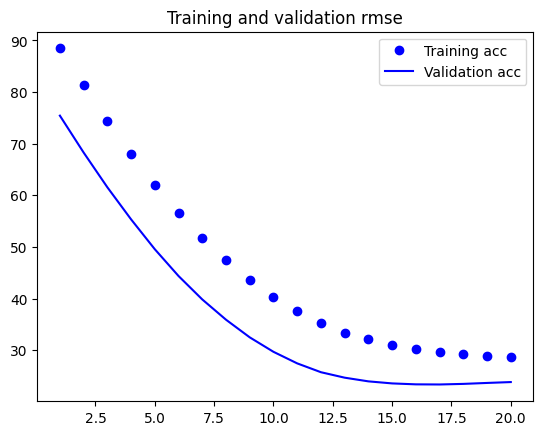

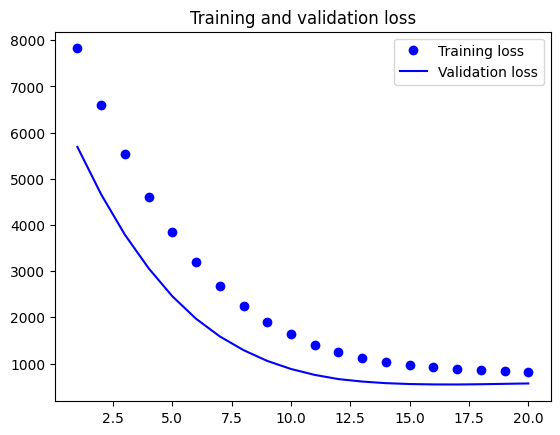

In [67]:
rmse = history1.history['root_mean_squared_error']
val_rmse = history1.history['val_root_mean_squared_error']
loss = history1.history['loss']
val_loss = history1.history['val_loss']


epochs = range(1, len(rmse) + 1)

plt.plot(epochs, rmse, 'bo', label='Training acc')
plt.plot(epochs, val_rmse, 'b', label='Validation acc')
plt.title('Training and validation rmse')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [68]:
dl_model_1.load_weights( "./checkpoints1" )
y1_predict = dl_model_1.predict(test_1_vec)
dl_sn_rmse = mean_squared_error( y_test1, y1_predict, squared=False ) 
print( dl_sn_rmse )

7/7 [==============================] - 0s 0s/step
32.70848773496306
